# Bayesian Temporal Matrix Factorization

**Published**: October 8, 2019

**Revised**: October 8, 2020

**Author**: Xinyu Chen [[**GitHub homepage**](https://github.com/xinychen)]

**Download**: This Jupyter notebook is at our GitHub repository. If you want to evaluate the code, please download the notebook from the [**transdim**](https://github.com/xinychen/transdim/blob/master/imputer/BTMF.ipynb) repository.

This notebook shows how to implement the Bayesian Temporal Matrix Factorization (BTMF), a fully Bayesian matrix factorization model, on some real-world data sets. To overcome the missing data problem in multivariate time series, BTMF takes into account both low-rank matrix structure and time series autoregression. For an in-depth discussion of BTMF, please see [1].

<div class="alert alert-block alert-info">
<font color="black">
<b>[1]</b> Xinyu Chen, Lijun Sun (2019). <b>Bayesian temporal factorization for multidimensional time series prediction</b>. arXiv:1910.06366. <a href="https://arxiv.org/pdf/1910.06366.pdf" title="PDF"><b>[PDF]</b></a> 
</font>
</div>

## Problem Description

We assume a spatiotemporal setting for multidimensional time series data throughout this work. In general, modern spatiotemporal data sets collected from sensor networks can be organized as matrix time series. For example, we can denote by matrix $Y\in\mathbb{R}^{N\times T}$ a multivariate time series collected from $N$ locations/sensors on $T$ time points, with each row $$\boldsymbol{y}_{i}=\left(y_{i,1},y_{i,2},...,y_{i,t-1},y_{i,t},y_{i,t+1},...,y_{i,T}\right)$$
corresponding to the time series collected at location $i$.

As mentioned, making accurate predictions on incomplete time series is very challenging, while missing data problem is almost inevitable in real-world applications. Figure 1 illustrates the prediction problem for incomplete time series data. Here we use $(i,t)\in\Omega$ to index the observed entries in matrix $Y$.

<img src="../images/graphical_matrix_time_series.png" alt="drawing" width="500"/>

> **Figure 1**: Illustration of multivariate time series and the prediction problem in the presence of missing values (green: observed data; white: missing data; red: prediction).


In [1]:
import numpy as np
from numpy.linalg import inv as inv
from numpy.random import normal as normrnd
from numpy.random import multivariate_normal as mvnrnd
from scipy.linalg import khatri_rao as kr_prod
from scipy.stats import wishart
from scipy.stats import invwishart
from numpy.linalg import solve as solve
from numpy.linalg import cholesky as cholesky_lower
from scipy.linalg import cholesky as cholesky_upper
from scipy.linalg import solve_triangular as solve_ut
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def mvnrnd_pre(mu, Lambda):
    src = normrnd(size = (mu.shape[0],))
    return solve_ut(cholesky_upper(Lambda, overwrite_a = True, check_finite = False), 
                    src, lower = False, check_finite = False, overwrite_b = True) + mu

def cov_mat(mat, mat_bar):
    mat = mat - mat_bar
    return mat.T @ mat

In [3]:
def sample_factor_w(tau_sparse_mat, tau_ind, W, X, tau, beta0 = 1, vargin = 0):
    """Sampling N-by-R factor matrix W and its hyperparameters (mu_w, Lambda_w)."""
    
    dim1, rank = W.shape
    W_bar = np.mean(W, axis = 0)
    temp = dim1 / (dim1 + beta0)
    var_W_hyper = inv(np.eye(rank) + cov_mat(W, W_bar) + temp * beta0 * np.outer(W_bar, W_bar))
    var_Lambda_hyper = wishart.rvs(df = dim1 + rank, scale = var_W_hyper)
    var_mu_hyper = mvnrnd_pre(temp * W_bar, (dim1 + beta0) * var_Lambda_hyper)
    
    if dim1 * rank ** 2 > 1e+8:
        vargin = 1
    
    if vargin == 0:
        var1 = X.T
        var2 = kr_prod(var1, var1)
        var3 = (var2 @ tau_ind.T).reshape([rank, rank, dim1]) + var_Lambda_hyper[:, :, None]
        var4 = var1 @ tau_sparse_mat.T + (var_Lambda_hyper @ var_mu_hyper)[:, None]
        for i in range(dim1):
            W[i, :] = mvnrnd_pre(solve(var3[:, :, i], var4[:, i]), var3[:, :, i])
    elif vargin == 1:
        for i in range(dim1):
            pos0 = np.where(sparse_mat[i, :] != 0)
            Xt = X[pos0[0], :]
            var_mu = tau[i] * Xt.T @ sparse_mat[i, pos0[0]] + var_Lambda_hyper @ var_mu_hyper
            var_Lambda = tau[i] * Xt.T @ Xt + var_Lambda_hyper
            W[i, :] = mvnrnd_pre(solve(var_Lambda, var_mu), var_Lambda)
    
    return W

In [4]:
def mnrnd(M, U, V):
    """
    Generate matrix normal distributed random matrix.
    M is a m-by-n matrix, U is a m-by-m matrix, and V is a n-by-n matrix.
    """
    dim1, dim2 = M.shape
    X0 = np.random.randn(dim1, dim2)
    P = cholesky_lower(U)
    Q = cholesky_lower(V)
    
    return M + P @ X0 @ Q.T

def sample_var_coefficient(X, time_lags):
    dim, rank = X.shape
    d = time_lags.shape[0]
    tmax = np.max(time_lags)
    
    Z_mat = X[tmax : dim, :]
    Q_mat = np.zeros((dim - tmax, rank * d))
    for k in range(d):
        Q_mat[:, k * rank : (k + 1) * rank] = X[tmax - time_lags[k] : dim - time_lags[k], :]
    var_Psi0 = np.eye(rank * d) + Q_mat.T @ Q_mat
    var_Psi = inv(var_Psi0)
    var_M = var_Psi @ Q_mat.T @ Z_mat
    var_S = np.eye(rank) + Z_mat.T @ Z_mat - var_M.T @ var_Psi0 @ var_M
    Sigma = invwishart.rvs(df = rank + dim - tmax, scale = var_S)
    
    return mnrnd(var_M, var_Psi, Sigma), Sigma

In [5]:
def sample_factor_x(tau_sparse_mat, tau_ind, time_lags, W, X, A, Lambda_x):
    """Sampling T-by-R factor matrix X."""
    
    dim2, rank = X.shape
    tmax = np.max(time_lags)
    tmin = np.min(time_lags)
    d = time_lags.shape[0]
    A0 = np.dstack([A] * d)
    for k in range(d):
        A0[k * rank : (k + 1) * rank, :, k] = 0
    mat0 = Lambda_x @ A.T
    mat1 = np.einsum('kij, jt -> kit', A.reshape([d, rank, rank]), Lambda_x)
    mat2 = np.einsum('kit, kjt -> ij', mat1, A.reshape([d, rank, rank]))
    
    var1 = W.T
    var2 = kr_prod(var1, var1)
    var3 = (var2 @ tau_ind).reshape([rank, rank, dim2]) + Lambda_x[:, :, None]
    var4 = var1 @ tau_sparse_mat
    for t in range(dim2):
        Mt = np.zeros((rank, rank))
        Nt = np.zeros(rank)
        Qt = mat0 @ X[t - time_lags, :].reshape(rank * d)
        index = list(range(0, d))
        if t >= dim2 - tmax and t < dim2 - tmin:
            index = list(np.where(t + time_lags < dim2))[0]
        elif t < tmax:
            Qt = np.zeros(rank)
            index = list(np.where(t + time_lags >= tmax))[0]
        if t < dim2 - tmin:
            Mt = mat2.copy()
            temp = np.zeros((rank * d, len(index)))
            n = 0
            for k in index:
                temp[:, n] = X[t + time_lags[k] - time_lags, :].reshape(rank * d)
                n += 1
            temp0 = X[t + time_lags[index], :].T - np.einsum('ijk, ik -> jk', A0[:, :, index], temp)
            Nt = np.einsum('kij, jk -> i', mat1[index, :, :], temp0)
        
        var3[:, :, t] = var3[:, :, t] + Mt
        if t < tmax:
            var3[:, :, t] = var3[:, :, t] - Lambda_x + np.eye(rank)
        X[t, :] = mvnrnd_pre(solve(var3[:, :, t], var4[:, t] + Nt + Qt), var3[:, :, t])

    return X

In [6]:
def sample_precision_tau(sparse_mat, mat_hat, ind):
    var_alpha = 1e-6 + 0.5 * np.sum(ind, axis = 1)
    var_beta = 1e-6 + 0.5 * np.sum(((sparse_mat - mat_hat) ** 2) * ind, axis = 1)
    return np.random.gamma(var_alpha, 1 / var_beta)

In [7]:
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

In [8]:
def ar4cast(A, X, Sigma, time_lags, multi_step):
    dim, rank = X.shape
    d = time_lags.shape[0]
    X_new = np.append(X, np.zeros((multi_step, rank)), axis = 0)
    for t in range(multi_step):
        var = A.T @ X_new[dim + t - time_lags, :].reshape(rank * d)
        X_new[dim + t, :] = mvnrnd(var, Sigma)
    return X_new

#### BTMF Implementation



In [9]:
def BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter, multi_step = 1):
    """Bayesian Temporal Matrix Factorization, BTMF."""
    
    dim1, dim2 = sparse_mat.shape
    d = time_lags.shape[0]
    W = init["W"]
    X = init["X"]
    pos_test = np.where((dense_mat != 0) & (sparse_mat == 0))
    dense_test = dense_mat[pos_test]
    del dense_mat
    ind = sparse_mat != 0
    pos_obs = np.where(ind)
    tau = np.ones(dim1)
    W_plus = np.zeros((dim1, rank, gibbs_iter))
    A_plus = np.zeros((rank * d, rank, gibbs_iter))
    tau_plus = np.zeros((dim1, gibbs_iter))
    Sigma_plus = np.zeros((rank, rank, gibbs_iter))
    temp_hat = np.zeros(len(pos_test[0]))
    show_iter = 500
    mat_hat_plus = np.zeros((dim1, dim2))
    X_plus = np.zeros((dim2 + multi_step, rank, gibbs_iter))
    mat_new_plus = np.zeros((dim1, multi_step))
    for it in range(burn_iter + gibbs_iter):
        tau_ind = tau[:, None] * ind
        tau_sparse_mat = tau[:, None] * sparse_mat
        W = sample_factor_w(tau_sparse_mat, tau_ind, W, X, tau, beta0 = 1, vargin = 0)
        A, Sigma = sample_var_coefficient(X, time_lags)
        X = sample_factor_x(tau_sparse_mat, tau_ind, time_lags, W, X, A, inv(Sigma))
        mat_hat = W @ X.T
        tau = sample_precision_tau(sparse_mat, mat_hat, ind)
        temp_hat += mat_hat[pos_test]
        if (it + 1) % show_iter == 0 and it < burn_iter:
            temp_hat = temp_hat / show_iter
            print('Iter: {}'.format(it + 1))
            print('MAPE: {:.6}'.format(compute_mape(dense_test, temp_hat)))
            print('RMSE: {:.6}'.format(compute_rmse(dense_test, temp_hat)))
            temp_hat = np.zeros(len(pos_test[0]))
            print()
        if it + 1 > burn_iter:
            W_plus[:, :, it - burn_iter] = W
            A_plus[:, :, it - burn_iter] = A
            Sigma_plus[:, :, it - burn_iter] = Sigma
            tau_plus[:, it - burn_iter] = tau
            mat_hat_plus += mat_hat
            X0 = ar4cast(A, X, Sigma, time_lags, multi_step)
            X_plus[:, :, it - burn_iter] = X0
            mat_new_plus += W @ X0[dim2 : dim2 + multi_step, :].T
    mat_hat = mat_hat_plus / gibbs_iter
    print('Imputation MAPE: {:.6}'.format(compute_mape(dense_test, mat_hat[:, : dim2][pos_test])))
    print('Imputation RMSE: {:.6}'.format(compute_rmse(dense_test, mat_hat[:, : dim2][pos_test])))
    print()
    mat_hat = np.append(mat_hat, mat_new_plus / gibbs_iter, axis = 1)
    mat_hat[mat_hat < 0] = 0
    
    return mat_hat, W_plus, X_plus, A_plus, Sigma_plus, tau_plus

In [10]:
def sample_factor_x_partial(tau_sparse_mat, tau_ind, time_lags, W, X, A, Lambda_x, back_step):
    """Sampling T-by-R factor matrix X."""
    
    dim2, rank = X.shape
    tmax = np.max(time_lags)
    tmin = np.min(time_lags)
    d = time_lags.shape[0]
    A0 = np.dstack([A] * d)
    for k in range(d):
        A0[k * rank : (k + 1) * rank, :, k] = 0
    mat0 = Lambda_x @ A.T
    mat1 = np.einsum('kij, jt -> kit', A.reshape([d, rank, rank]), Lambda_x)
    mat2 = np.einsum('kit, kjt -> ij', mat1, A.reshape([d, rank, rank]))
    
    var1 = W.T
    var2 = kr_prod(var1, var1)
    var3 = (var2 @ tau_ind[:, - back_step :]).reshape([rank, rank, back_step]) + Lambda_x[:, :, None]
    var4 = var1 @ tau_sparse_mat[:, - back_step :]
    for t in range(dim2 - back_step, dim2):
        Mt = np.zeros((rank, rank))
        Nt = np.zeros(rank)
        Qt = mat0 @ X[t - time_lags, :].reshape(rank * d)
        index = list(range(0, d))
        if t >= dim2 - tmax and t < dim2 - tmin:
            index = list(np.where(t + time_lags < dim2))[0]
        if t < dim2 - tmin:
            Mt = mat2.copy()
            temp = np.zeros((rank * d, len(index)))
            n = 0
            for k in index:
                temp[:, n] = X[t + time_lags[k] - time_lags, :].reshape(rank * d)
                n += 1
            temp0 = X[t + time_lags[index], :].T - np.einsum('ijk, ik -> jk', A0[:, :, index], temp)
            Nt = np.einsum('kij, jk -> i', mat1[index, :, :], temp0)
        var3[:, :, t + back_step - dim2] = var3[:, :, t + back_step - dim2] + Mt
        X[t, :] = mvnrnd_pre(solve(var3[:, :, t + back_step - dim2], 
                                   var4[:, t + back_step - dim2] + Nt + Qt), var3[:, :, t + back_step - dim2])
    return X

In [11]:
def BTMF_partial(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter, multi_step = 1):
    """Bayesian Temporal Matrix Factorization, BTMF."""
    
    dim1, dim2 = sparse_mat.shape
    W_plus = init["W_plus"]
    X_plus = init["X_plus"]
    A_plus = init["A_plus"]
    Sigma_plus = init["Sigma_plus"]
    tau_plus = init["tau_plus"]
    ind = sparse_mat != 0
    pos_obs = np.where(ind)
    X_new_plus = np.zeros((dim2 + multi_step, rank, gibbs_iter))
    mat_new_plus = np.zeros((dim1, multi_step))
    back_step = 10 * multi_step
    for it in range(gibbs_iter):
        tau_ind = tau_plus[:, it][:, None] * ind
        tau_sparse_mat = tau_plus[:, it][:, None] * sparse_mat
        X = sample_factor_x_partial(tau_sparse_mat, tau_ind, time_lags, W_plus[:, :, it], 
                                    X_plus[:, :, it], A_plus[:, :, it], inv(Sigma_plus[:, :, it]), back_step)
        X0 = ar4cast(A_plus[:, :, it], X, Sigma_plus[:, :, it], time_lags, multi_step)
        X_new_plus[:, :, it] = X0
        mat_new_plus += W_plus[:, :, it] @ X0[- multi_step :, :].T
    mat_hat = mat_new_plus / gibbs_iter
    mat_hat[mat_hat < 0] = 0
    
    return mat_hat, W_plus, X_new_plus, A_plus, Sigma_plus, tau_plus

In [12]:
from ipywidgets import IntProgress
from IPython.display import display

def BTMF_forecast(dense_mat, sparse_mat, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter):
    T = dense_mat.shape[1]
    start_time = T - pred_step
    dim1 = dense_mat.shape[0]
    max_count = int(np.ceil(pred_step / multi_step))
    mat_hat = np.zeros((dim1, max_count * multi_step))
    f = IntProgress(min = 0, max = max_count) # instantiate the bar
    display(f) # display the bar
    for t in range(max_count):
        if t == 0:
            init = {"W": 0.1 * np.random.randn(dim1, rank), "X": 0.1 * np.random.randn(start_time, rank)}
            mat, W, X_new, A, Sigma, tau = BTMF(dense_mat[:, 0 : start_time], 
                sparse_mat[:, 0 : start_time], init, rank, time_lags, burn_iter, gibbs_iter, multi_step)
        else:
            init = {"W_plus": W, "X_plus": X_new, "A_plus": A, "Sigma_plus": Sigma, "tau_plus": tau}
            mat, W, X_new, A, Sigma, tau = BTMF_partial(dense_mat[:, 0 : start_time + t * multi_step], 
                sparse_mat[:, 0 : start_time + t * multi_step], init, rank, time_lags, 
                                                        burn_iter, gibbs_iter, multi_step)
        mat_hat[:, t * multi_step : (t + 1) * multi_step] = mat[:, - multi_step :]
        f.value = t
    small_dense_mat = dense_mat[:, start_time : dense_mat.shape[1]]
    pos = np.where(small_dense_mat != 0)
    print('Prediction MAPE: {:.6}'.format(compute_mape(small_dense_mat[pos], mat_hat[pos])))
    print('Prediction RMSE: {:.6}'.format(compute_rmse(small_dense_mat[pos], mat_hat[pos])))
    print()
    return mat_hat

## Imputation Performance of BTMF on London Movement Data

In [13]:
import numpy as np
np.random.seed(1000)

missing_rate = 0.6

dense_mat = np.load('../datasets/London-data-set/hourly_speed_mat.npy')
binary_mat = dense_mat.copy()
binary_mat[binary_mat != 0] = 1
pos = np.where(np.sum(binary_mat, axis = 1) > 0.7 * binary_mat.shape[1])
dense_mat = dense_mat[pos[0], :]

## Random missing (RM)
random_mat = np.random.rand(dense_mat.shape[0], dense_mat.shape[1])
binary_mat = np.round(random_mat + 0.5 - missing_rate)
sparse_mat = dense_mat * binary_mat

In [14]:
import time
start = time.time()
dim1, dim2 = sparse_mat.shape
rank = 20
time_lags = np.array([1, 2, 24])
init = {"W": 0.01 * np.random.randn(dim1, rank), "X": 0.01 * np.random.randn(dim2, rank)}
burn_iter = 1000
gibbs_iter = 200
mat_hat, W, X, A, Sigma, tau = BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter)
mat_hat = mat_hat[:, : -1]
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 500
MAPE: 0.0973495
RMSE: 2.42629

Iter: 1000
MAPE: 0.0932676
RMSE: 2.29969

Imputation MAPE: 0.0931991
Imputation RMSE: 2.29774

Running time: 3660 seconds


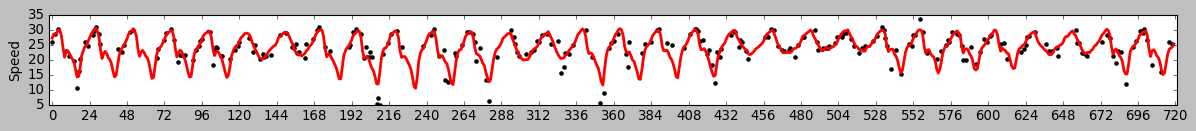

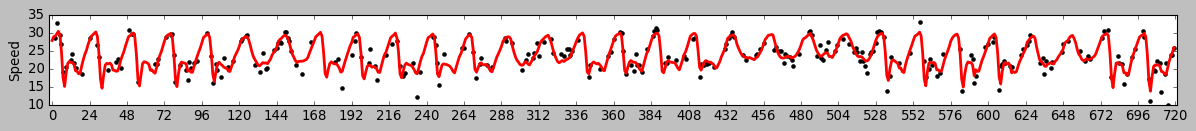

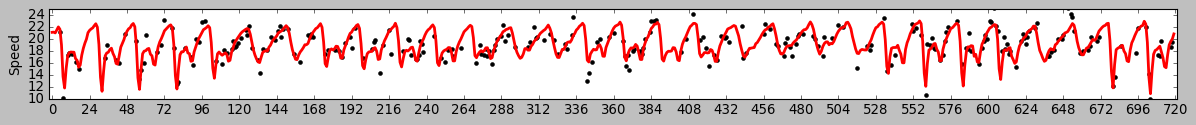

In [33]:
for loc in [0, 1, 2]:
    plt.style.use('classic')
    fig = plt.figure(figsize = (15, 1.5))
    ax = fig.add_axes([0.04, 0.18, 0.94, 0.75])
#     pos = np.where((dense_mat[loc, :] > 0) & (sparse_mat[loc, :] == 0))
#     plt.plot(pos[0], dense_mat[loc, pos[0]], '.', markersize = 6, color = "blue")
    pos = np.where(sparse_mat[loc, :] > 0)
    plt.plot(pos[0], dense_mat[loc, pos[0]], '.', markersize = 7, color = "black")
    plt.plot(mat_hat[loc, :], color = 'red', linewidth = 2.5)
    plt.xticks(np.arange(0, 24 * 30 + 1, 24))
    plt.xlim([-2, 24 * 30 + 1])
    if loc == 0:
        plt.ylim([5, 35])
    elif loc == 1:
        plt.ylim([10, 35])
    elif loc == 2:
        plt.ylim([10, 25])
    plt.ylabel('Speed')
    plt.show()
    fig.savefig("../images/BTMF_imputation_London_{}.pdf".format(loc + 1))

## Prediction Performance of BTMF on London Movement Data

In [13]:
import numpy as np
np.random.seed(1000)

missing_rate = 0.4

dense_mat = np.load('../datasets/London-data-set/hourly_speed_mat.npy')
binary_mat = dense_mat.copy()
binary_mat[binary_mat != 0] = 1
pos = np.where(np.sum(binary_mat, axis = 1) > 0.7 * binary_mat.shape[1])
dense_mat = dense_mat[pos[0], :]

## Non-random missing (NM)
binary_mat = np.zeros(dense_mat.shape)
random_mat = np.random.rand(dense_mat.shape[0], 30)
for i1 in range(dense_mat.shape[0]):
    for i2 in range(30):
        binary_mat[i1, i2 * 24 : (i2 + 1) * 24] = np.round(random_mat[i1, i2] + 0.5 - missing_rate)
sparse_mat = np.multiply(dense_mat, binary_mat)

In [14]:
import time
rank = 10
pred_step = 7 * 24
time_lags = np.array([1, 2, 3, 24, 25, 26, 7 * 24, 7 * 24 + 1, 7 * 24 + 2])
burn_iter = 1000
gibbs_iter = 200
multi_step = 6
start = time.time()
print('Prediction time horizon (delta) = {}.'.format(multi_step))
mat_hat = BTMF_forecast(dense_mat, sparse_mat, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))
print()

Prediction time horizon (delta) = 6.


IntProgress(value=0, max=28)

Iter: 500
MAPE: 0.0955807
RMSE: 2.36991

Iter: 1000
MAPE: 0.0955983
RMSE: 2.36957

Imputation MAPE: 0.0955979
Imputation RMSE: 2.36956

Prediction MAPE: 0.120632
Prediction RMSE: 2.84188

Running time: 6251 seconds



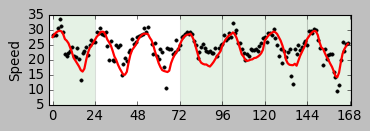

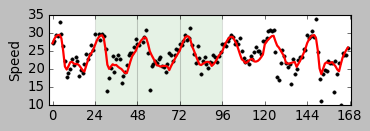

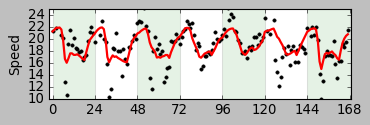

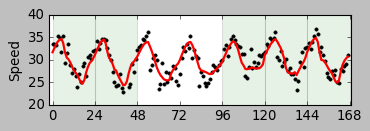

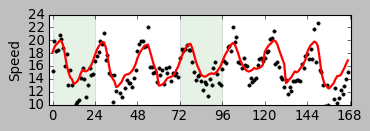

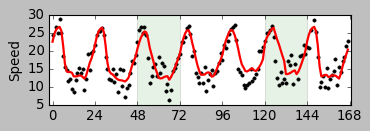

In [40]:
import matplotlib.patches as patches

sparse_mat0 = sparse_mat[:, - 7 * 24 :]
dense_mat0 = dense_mat[:, - 7 * 24 :]
for loc in [0, 1, 2, 3, 4, 5]:
    plt.style.use('classic')
    fig = plt.figure(figsize = (4.5, 1.5))
    ax = fig.add_axes([0.12, 0.18, 0.84, 0.75])
    for j in range(7):
        if sparse_mat0[loc, 24 * j] > 0:
            someX, someY = j * 24, 0
            currentAxis = plt.gca()
            ax.add_patch(patches.Rectangle((someX, someY), 24, 60, alpha = 0.1, facecolor = 'green'))
    pos = np.where(sparse_mat0[loc, :] > 0)
    plt.plot(dense_mat0[loc, :], '.', markersize = 6, color = "black")
#     plt.plot(pos[0], dense_mat0[loc, pos[0]], '.', markersize = 6, color = "black")
#     pos = np.where(sparse_mat0[loc, :] == 0)
#     plt.plot(pos[0], dense_mat0[loc, pos[0]], '.', markersize = 7, color = "gray")
    plt.plot(mat_hat[loc, :], color = 'red', linewidth = 2)
    plt.xticks(np.arange(0, 24 * 7 + 1, 24))
    plt.xlim([-2, 24 * 7 + 1])
    if loc == 0:
        plt.ylim([5, 35])
    elif loc == 1:
        plt.ylim([10, 35])
    elif loc == 2:
        plt.ylim([10, 25])
    elif loc == 3:
        plt.ylim([20, 40])
    elif loc == 4:
        plt.ylim([10, 24])
    elif loc == 5:
        plt.ylim([5, 30])
    plt.ylabel('Speed')
    plt.show()
    fig.savefig("../images/BTMF_prediction_London_{}.pdf".format(loc + 1))

## Evaluation on Hangzhou Flow Data



**Scenario setting**:

- Tensor size: $80\times 25\times 108$ (metro station, day, time of day)
- Non-random missing (NM)
- 40% missing rate


In [41]:
import time
import scipy.io
import numpy as np
np.random.seed(1000)

dense_tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/tensor.mat')['tensor']
dim = dense_tensor.shape
missing_rate = 0.4 # Non-random missing (NM)
sparse_tensor = dense_tensor * np.round(np.random.rand(dim[0], dim[1])[:, :, np.newaxis] + 0.5 - missing_rate)
dense_mat = dense_tensor.reshape([dim[0], dim[1] * dim[2]])
sparse_mat = sparse_tensor.reshape([dim[0], dim[1] * dim[2]])
del dense_tensor, sparse_tensor

**Model setting**:

- Low rank: 10
- Total (rolling) prediction horizons: 7 * 108
- Time lags: {1, 2, 108, 108 + 1, 108 + 2, 7 * 108, 7 * 108 + 1, 7 * 108 + 2}
- The number of burn-in iterations: 1000
- The number of Gibbs iterations: 200

In [42]:
import time
rank = 10
pred_step = 7 * 108
time_lags = np.array([1, 2, 3, 108, 109, 110, 7 * 108, 7 * 108 + 1, 7 * 108 + 2])
burn_iter = 1000
gibbs_iter = 200
multi_step = 6
start = time.time()
print('Prediction time horizon (delta) = {}.'.format(multi_step))
mat_hat = BTMF_forecast(dense_mat, sparse_mat, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))
print()

Prediction time horizon (delta) = 6.


IntProgress(value=0, max=126)

Iter: 500
MAPE: 0.448764
RMSE: 113.958

Iter: 1000
MAPE: 0.274373
RMSE: 47.6628

Imputation MAPE: 0.242758
Imputation RMSE: 44.7998

Prediction MAPE: 0.302211
Prediction RMSE: 49.4928

Running time: 600 seconds



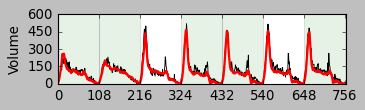

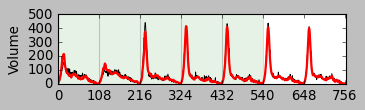

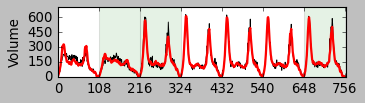

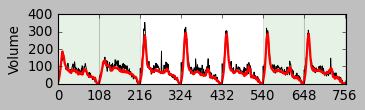

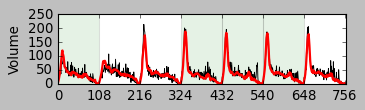

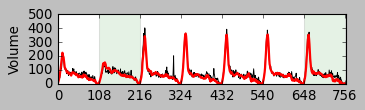

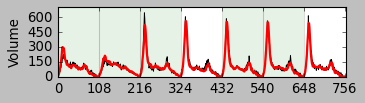

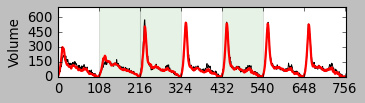

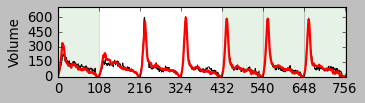

In [58]:
import matplotlib.patches as patches

sparse_mat0 = sparse_mat[:, - 7 * 108 :]
dense_mat0 = dense_mat[:, - 7 * 108 :]
for loc in [0, 1, 2, 30, 31, 32, 60, 61, 62]:
    plt.style.use('classic')
    fig = plt.figure(figsize = (4.5, 1.2))
    ax = fig.add_axes([0.15, 0.20, 0.80, 0.72])
    for j in range(7):
        if sparse_mat0[loc, 108 * j] > 0:
            someX, someY = j * 108, 0
            currentAxis = plt.gca()
            ax.add_patch(patches.Rectangle((someX, someY), 108, 700, alpha = 0.1, facecolor = 'green'))
    pos = np.where(sparse_mat0[loc, :] > 0)
    plt.plot(dense_mat0[loc, :], color = "black", linewidth = 0.8)
    plt.plot(mat_hat[loc, :], color = 'red', linewidth = 2)
    plt.xticks(np.arange(0, 108 * 7 + 1, 108))
    plt.xlim([-2, 108 * 7 + 1])
    if loc == 0:
        plt.ylim([0, 600])
        plt.yticks(np.arange(0, 600+1, 150))
    elif loc == 1:
        plt.ylim([0, 500])
        plt.yticks(np.arange(0, 500+1, 100))
    elif loc == 2:
        plt.ylim([0, 700])
        plt.yticks(np.arange(0, 700+1, 150))
    elif loc == 30:
        plt.ylim([0, 400])
        plt.yticks(np.arange(0, 400+1, 100))
    elif loc == 31:
        plt.ylim([0, 250])
        plt.yticks(np.arange(0, 250+1, 50))
    elif loc == 32:
        plt.ylim([0, 500])
        plt.yticks(np.arange(0, 500+1, 100))
    elif loc == 60:
        plt.ylim([0, 700])
        plt.yticks(np.arange(0, 700+1, 150))
    elif loc == 61:
        plt.ylim([0, 700])
        plt.yticks(np.arange(0, 700+1, 150))
    elif loc == 62:
        plt.ylim([0, 700])
        plt.yticks(np.arange(0, 700+1, 150))
    plt.ylabel('Volume')
    plt.show()
    fig.savefig("../images/H_time_series_volume_{}.pdf".format(loc + 1))

**Scenario setting**:

- Tensor size: $80\times 25\times 108$ (metro station, day, time of day)
- Random missing (RM)
- 60% missing rate


In [27]:
import time
import scipy.io
import numpy as np
np.random.seed(1000)

dense_tensor = scipy.io.loadmat('../datasets/Hangzhou-data-set/tensor.mat')['tensor']
dim = dense_tensor.shape
missing_rate = 0.6 # Random missing (RM)
sparse_tensor = dense_tensor * np.round(np.random.rand(dim[0], dim[1], dim[2]) + 0.5 - missing_rate)
dense_mat = dense_tensor.reshape([dim[0], dim[1] * dim[2]])
sparse_mat = sparse_tensor.reshape([dim[0], dim[1] * dim[2]])
del dense_tensor, sparse_tensor

**Model setting**:

- Low rank: 10
- Total (rolling) prediction horizons: 7 * 108
- Time lags: {1, 2, 108, 108 + 1, 108 + 2, 7 * 108, 7 * 108 + 1, 7 * 108 + 2}
- The number of burn-in iterations: 1000
- The number of Gibbs iterations: 200

In [28]:
import time
rank = 10
pred_step = 7 * 108
time_lags = np.array([1, 2, 3, 108, 109, 110, 7 * 108, 7 * 108 + 1, 7 * 108 + 2])
burn_iter = 1000
gibbs_iter = 200
for multi_step in [2, 4, 6, 12, 18, 24, 30, 36, 42, 48, 54]:
    start = time.time()
    print('Prediction time horizon (delta) = {}.'.format(multi_step))
    mat_hat = BTMF_forecast(dense_mat, sparse_mat, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter)
    end = time.time()
    print('Running time: %d seconds'%(end - start))
    print()

Prediction time horizon (delta) = 2.


IntProgress(value=0, max=378)

Iter: 500
MAPE: 0.245447
RMSE: 46.2954

Iter: 1000
MAPE: 0.251494
RMSE: 45.6868

Imputation MAPE: 0.253889
Imputation RMSE: 45.6802

Prediction MAPE: 0.270133
Prediction RMSE: 44.1042

Running time: 670 seconds

Prediction time horizon (delta) = 4.


IntProgress(value=0, max=189)

Iter: 500
MAPE: 0.247711
RMSE: 46.4123

Iter: 1000
MAPE: 0.249532
RMSE: 45.6559

Imputation MAPE: 0.247246
Imputation RMSE: 44.8514

Prediction MAPE: 0.268741
Prediction RMSE: 46.2648

Running time: 596 seconds

Prediction time horizon (delta) = 6.


IntProgress(value=0, max=126)

Iter: 500
MAPE: 0.246356
RMSE: 46.6452

Iter: 1000
MAPE: 0.244988
RMSE: 45.103

Imputation MAPE: 0.245741
Imputation RMSE: 44.8667

Prediction MAPE: 0.30019
Prediction RMSE: 47.3052

Running time: 571 seconds

Prediction time horizon (delta) = 12.


IntProgress(value=0, max=63)

Iter: 500
MAPE: 0.256522
RMSE: 46.4677

Iter: 1000
MAPE: 0.247965
RMSE: 45.5669

Imputation MAPE: 0.252812
Imputation RMSE: 45.6676

Prediction MAPE: 0.49162
Prediction RMSE: 78.7879

Running time: 550 seconds

Prediction time horizon (delta) = 18.


IntProgress(value=0, max=42)

Iter: 500
MAPE: 0.247762
RMSE: 46.4064

Iter: 1000
MAPE: 0.244871
RMSE: 44.8544

Imputation MAPE: 0.248846
Imputation RMSE: 44.8302

Prediction MAPE: 0.329638
Prediction RMSE: 48.5739

Running time: 548 seconds

Prediction time horizon (delta) = 24.


IntProgress(value=0, max=32)

Iter: 500
MAPE: 0.247753
RMSE: 46.272

Iter: 1000
MAPE: 0.250279
RMSE: 45.7288

Imputation MAPE: 0.250605
Imputation RMSE: 45.6028

Prediction MAPE: 0.48386
Prediction RMSE: 65.1364

Running time: 550 seconds

Prediction time horizon (delta) = 30.


IntProgress(value=0, max=26)

Iter: 500
MAPE: 0.246737
RMSE: 46.3298

Iter: 1000
MAPE: 0.246565
RMSE: 45.033

Imputation MAPE: 0.248064
Imputation RMSE: 44.7994

Prediction MAPE: 0.313136
Prediction RMSE: 48.9243

Running time: 558 seconds

Prediction time horizon (delta) = 36.


IntProgress(value=0, max=21)

Iter: 500
MAPE: 0.248365
RMSE: 46.7594

Iter: 1000
MAPE: 0.244709
RMSE: 44.8232

Imputation MAPE: 0.24877
Imputation RMSE: 44.8661

Prediction MAPE: 0.317078
Prediction RMSE: 48.8716

Running time: 543 seconds

Prediction time horizon (delta) = 42.


IntProgress(value=0, max=18)

Iter: 500
MAPE: 0.248345
RMSE: 46.5185

Iter: 1000
MAPE: 0.245469
RMSE: 44.8312

Imputation MAPE: 0.250308
Imputation RMSE: 44.8471

Prediction MAPE: 0.360375
Prediction RMSE: 51.8993

Running time: 541 seconds

Prediction time horizon (delta) = 48.


IntProgress(value=0, max=16)

Iter: 500
MAPE: 0.241355
RMSE: 46.0682

Iter: 1000
MAPE: 0.245772
RMSE: 44.8256

Imputation MAPE: 0.246172
Imputation RMSE: 44.8468

Prediction MAPE: 0.315255
Prediction RMSE: 51.169

Running time: 549 seconds

Prediction time horizon (delta) = 54.


IntProgress(value=0, max=14)

Iter: 500
MAPE: 0.252981
RMSE: 46.5808

Iter: 1000
MAPE: 0.250108
RMSE: 45.7151

Imputation MAPE: 0.24693
Imputation RMSE: 44.6762

Prediction MAPE: 0.352228
Prediction RMSE: 52.561

Running time: 549 seconds



## Evaluation on Seattle Speed Data



**Scenario setting**:

- Tensor size: $323\times 28\times 288$ (road segment, day, time of day)
- Test on original data


In [29]:
import pandas as pd
import warnings
warnings.simplefilter('ignore')

dense_mat = pd.read_csv('../datasets/Seattle-data-set/mat.csv', index_col = 0)
dense_mat = dense_mat.values
sparse_mat = dense_mat.copy()

**Model setting**:

- Low rank: 10
- Total (rolling) prediction horizons: 7 * 288
- Time lags: {1, 2, 288, 288 + 1, 288 + 2, 7 * 288, 7 * 288 + 1, 7 * 288 + 2}
- The number of burn-in iterations: 1000
- The number of Gibbs iterations: 200

In [30]:
import time
rank = 10
pred_step = 7 * 288
time_lags = np.array([1, 2, 3, 288, 289, 290, 7 * 288, 7 * 288 + 1, 7 * 288 + 2])
burn_iter = 1000
gibbs_iter = 200
for multi_step in [2, 4, 6, 12, 18, 24, 30, 36, 42, 48, 54]:
    start = time.time()
    print('Prediction time horizon (delta) = {}.'.format(multi_step))
    mat_hat = BTMF_forecast(dense_mat, sparse_mat, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter)
    end = time.time()
    print('Running time: %d seconds'%(end - start))
    print()

Prediction time horizon (delta) = 2.


IntProgress(value=0, max=1008)

Iter: 500
MAPE: nan
RMSE: nan

Iter: 1000
MAPE: nan
RMSE: nan

Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.103915
Prediction RMSE: 5.63268

Running time: 4625 seconds

Prediction time horizon (delta) = 4.


IntProgress(value=0, max=504)

Iter: 500
MAPE: nan
RMSE: nan

Iter: 1000
MAPE: nan
RMSE: nan

Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.108246
Prediction RMSE: 5.8263

Running time: 3034 seconds

Prediction time horizon (delta) = 6.


IntProgress(value=0, max=336)

Iter: 500
MAPE: nan
RMSE: nan

Iter: 1000
MAPE: nan
RMSE: nan

Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.111849
Prediction RMSE: 6.0227

Running time: 2540 seconds

Prediction time horizon (delta) = 12.


IntProgress(value=0, max=168)

Iter: 500
MAPE: nan
RMSE: nan

Iter: 1000
MAPE: nan
RMSE: nan

Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.122567
Prediction RMSE: 6.52976

Running time: 2063 seconds

Prediction time horizon (delta) = 18.


IntProgress(value=0, max=112)

Iter: 500
MAPE: nan
RMSE: nan

Iter: 1000
MAPE: nan
RMSE: nan

Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.12915
Prediction RMSE: 6.85351

Running time: 1896 seconds

Prediction time horizon (delta) = 24.


IntProgress(value=0, max=84)

Iter: 500
MAPE: nan
RMSE: nan

Iter: 1000
MAPE: nan
RMSE: nan

Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.13476
Prediction RMSE: 7.124

Running time: 1824 seconds

Prediction time horizon (delta) = 30.


IntProgress(value=0, max=68)

Iter: 500
MAPE: nan
RMSE: nan

Iter: 1000
MAPE: nan
RMSE: nan

Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.137889
Prediction RMSE: 7.31484

Running time: 1794 seconds

Prediction time horizon (delta) = 36.


IntProgress(value=0, max=56)

Iter: 500
MAPE: nan
RMSE: nan

Iter: 1000
MAPE: nan
RMSE: nan

Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.140115
Prediction RMSE: 7.45912

Running time: 1950 seconds

Prediction time horizon (delta) = 42.


IntProgress(value=0, max=48)

Iter: 500
MAPE: nan
RMSE: nan

Iter: 1000
MAPE: nan
RMSE: nan

Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.144885
Prediction RMSE: 7.69699

Running time: 1876 seconds

Prediction time horizon (delta) = 48.


IntProgress(value=0, max=42)

Iter: 500
MAPE: nan
RMSE: nan

Iter: 1000
MAPE: nan
RMSE: nan

Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.143099
Prediction RMSE: 7.54653

Running time: 1830 seconds

Prediction time horizon (delta) = 54.


IntProgress(value=0, max=38)

Iter: 500
MAPE: nan
RMSE: nan

Iter: 1000
MAPE: nan
RMSE: nan

Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.1424
Prediction RMSE: 7.6484

Running time: 1917 seconds



**Scenario setting**:

- Tensor size: $323\times 28\times 288$ (road segment, day, time of day)
- Non-random missing (NM)
- 40% missing rate


In [31]:
import time
import scipy.io
import numpy as np
np.random.seed(1000)

dense_tensor = scipy.io.loadmat('../datasets/Seattle-data-set/tensor.npz')['arr_0']
dim = dense_tensor.shape
missing_rate = 0.4 # Non-random missing (NM)
sparse_tensor = dense_tensor * np.round(np.random.rand(dim[0], dim[1])[:, :, np.newaxis] + 0.5 - missing_rate)
dense_mat = dense_tensor.reshape([dim[0], dim[1] * dim[2]])
sparse_mat = sparse_tensor.reshape([dim[0], dim[1] * dim[2]])
del dense_tensor, sparse_tensor

**Model setting**:

- Low rank: 10
- Total (rolling) prediction horizons: 7 * 288
- Time lags: {1, 2, 288, 288 + 1, 288 + 2, 7 * 288, 7 * 288 + 1, 7 * 288 + 2}
- The number of burn-in iterations: 1000
- The number of Gibbs iterations: 200

In [32]:
import time
rank = 10
pred_step = 7 * 288
time_lags = np.array([1, 2, 3, 288, 289, 290, 7 * 288, 7 * 288 + 1, 7 * 288 + 2])
burn_iter = 1000
gibbs_iter = 200
for multi_step in [2, 4, 6, 12, 18, 24, 30, 36, 42, 48, 54]:
    start = time.time()
    print('Prediction time horizon (delta) = {}.'.format(multi_step))
    mat_hat = BTMF_forecast(dense_mat, sparse_mat, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter)
    end = time.time()
    print('Running time: %d seconds'%(end - start))
    print()

Prediction time horizon (delta) = 2.


IntProgress(value=0, max=1008)

Iter: 500
MAPE: 0.110953
RMSE: 8.39262

Iter: 1000
MAPE: 0.100398
RMSE: 6.22308

Imputation MAPE: 0.0943361
Imputation RMSE: 5.49515

Prediction MAPE: 0.109344
Prediction RMSE: 5.95936

Running time: 4668 seconds

Prediction time horizon (delta) = 4.


IntProgress(value=0, max=504)

Iter: 500
MAPE: 0.0939913
RMSE: 5.4574

Iter: 1000
MAPE: 0.0925024
RMSE: 5.40891

Imputation MAPE: 0.0930147
Imputation RMSE: 5.42341

Prediction MAPE: 0.111674
Prediction RMSE: 6.03488

Running time: 2999 seconds

Prediction time horizon (delta) = 6.


IntProgress(value=0, max=336)

Iter: 500
MAPE: 0.09443
RMSE: 5.48588

Iter: 1000
MAPE: 0.0926028
RMSE: 5.42041

Imputation MAPE: 0.0930061
Imputation RMSE: 5.42559

Prediction MAPE: 0.115497
Prediction RMSE: 6.24488

Running time: 2514 seconds

Prediction time horizon (delta) = 12.


IntProgress(value=0, max=168)

Iter: 500
MAPE: 0.0994011
RMSE: 6.06813

Iter: 1000
MAPE: 0.0934044
RMSE: 5.45001

Imputation MAPE: 0.0930714
Imputation RMSE: 5.44275

Prediction MAPE: 0.125829
Prediction RMSE: 6.83639

Running time: 2078 seconds

Prediction time horizon (delta) = 18.


IntProgress(value=0, max=112)

Iter: 500
MAPE: 0.121187
RMSE: 10.9708

Iter: 1000
MAPE: 0.120805
RMSE: 11.4795

Imputation MAPE: 0.110132
Imputation RMSE: 9.00999

Prediction MAPE: 0.134262
Prediction RMSE: 7.33078

Running time: 2004 seconds

Prediction time horizon (delta) = 24.


IntProgress(value=0, max=84)

Iter: 500
MAPE: 0.094032
RMSE: 5.45514

Iter: 1000
MAPE: 0.0941873
RMSE: 5.48124

Imputation MAPE: 0.0935952
Imputation RMSE: 5.47326

Prediction MAPE: 0.137426
Prediction RMSE: 7.51186

Running time: 1907 seconds

Prediction time horizon (delta) = 30.


IntProgress(value=0, max=68)

Iter: 500
MAPE: 0.0945662
RMSE: 5.49106

Iter: 1000
MAPE: 0.0945183
RMSE: 5.49872

Imputation MAPE: 0.0944762
Imputation RMSE: 5.49405

Prediction MAPE: 0.141948
Prediction RMSE: 7.87497

Running time: 1847 seconds

Prediction time horizon (delta) = 36.


IntProgress(value=0, max=56)

Iter: 500
MAPE: 0.0944593
RMSE: 5.47713

Iter: 1000
MAPE: 0.0944714
RMSE: 5.49525

Imputation MAPE: 0.0940964
Imputation RMSE: 5.47943

Prediction MAPE: 0.143435
Prediction RMSE: 8.00036

Running time: 1855 seconds

Prediction time horizon (delta) = 42.


IntProgress(value=0, max=48)

Iter: 500
MAPE: 0.0943425
RMSE: 5.47328

Iter: 1000
MAPE: 0.0944343
RMSE: 5.49189

Imputation MAPE: 0.0940909
Imputation RMSE: 5.48087

Prediction MAPE: 0.147405
Prediction RMSE: 8.22826

Running time: 1801 seconds

Prediction time horizon (delta) = 48.


IntProgress(value=0, max=42)

Iter: 500
MAPE: 0.0946713
RMSE: 5.48873

Iter: 1000
MAPE: 0.0930694
RMSE: 5.43538

Imputation MAPE: 0.0930566
Imputation RMSE: 5.43729

Prediction MAPE: 0.146669
Prediction RMSE: 8.02032

Running time: 5242 seconds

Prediction time horizon (delta) = 54.


IntProgress(value=0, max=38)

Iter: 500
MAPE: 0.126667
RMSE: 10.0194

Iter: 1000
MAPE: 0.0948734
RMSE: 5.69245

Imputation MAPE: 0.0945119
Imputation RMSE: 5.49562

Prediction MAPE: 0.145766
Prediction RMSE: 8.13409

Running time: 1869 seconds



**Scenario setting**:

- Tensor size: $323\times 28\times 288$ (road segment, day, time of day)
- Random missing (RM)
- 40% missing rate


In [33]:
import time
import scipy.io
import numpy as np
np.random.seed(1000)

dense_tensor = scipy.io.loadmat('../datasets/Seattle-data-set/tensor.npz')['arr_0']
dim = dense_tensor.shape
missing_rate = 0.4 # Random missing (RM)
sparse_tensor = dense_tensor * np.round(np.random.rand(dim[0], dim[1], dim[2]) + 0.5 - missing_rate)
dense_mat = dense_tensor.reshape([dim[0], dim[1] * dim[2]])
sparse_mat = sparse_tensor.reshape([dim[0], dim[1] * dim[2]])
del dense_tensor, sparse_tensor

**Model setting**:

- Low rank: 10
- Total (rolling) prediction horizons: 7 * 288
- Time lags: {1, 2, 288, 288 + 1, 288 + 2, 7 * 288, 7 * 288 + 1, 7 * 288 + 2}
- The number of burn-in iterations: 1000
- The number of Gibbs iterations: 200

In [34]:
import time
rank = 10
pred_step = 7 * 288
time_lags = np.array([1, 2, 3, 288, 289, 290, 7 * 288, 7 * 288 + 1, 7 * 288 + 2])
burn_iter = 1000
gibbs_iter = 200
for multi_step in [2, 4, 6, 12, 18, 24, 30, 36, 42, 48, 54]:
    start = time.time()
    print('Prediction time horizon (delta) = {}.'.format(multi_step))
    mat_hat = BTMF_forecast(dense_mat, sparse_mat, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter)
    end = time.time()
    print('Running time: %d seconds'%(end - start))
    print()

Prediction time horizon (delta) = 2.


IntProgress(value=0, max=1008)

Iter: 500
MAPE: 0.0877406
RMSE: 5.10053

Iter: 1000
MAPE: 0.0858127
RMSE: 5.01607

Imputation MAPE: 0.085745
Imputation RMSE: 5.01486

Prediction MAPE: 0.10521
Prediction RMSE: 5.68526

Running time: 7172 seconds

Prediction time horizon (delta) = 4.


IntProgress(value=0, max=504)

Iter: 500
MAPE: 0.0877946
RMSE: 5.10282

Iter: 1000
MAPE: 0.086276
RMSE: 5.03992

Imputation MAPE: 0.08575
Imputation RMSE: 5.01635

Prediction MAPE: 0.109627
Prediction RMSE: 5.89403

Running time: 4134 seconds

Prediction time horizon (delta) = 6.


IntProgress(value=0, max=336)

Iter: 500
MAPE: 0.0879834
RMSE: 5.10792

Iter: 1000
MAPE: 0.0862167
RMSE: 5.03691

Imputation MAPE: 0.0857423
Imputation RMSE: 5.01532

Prediction MAPE: 0.113731
Prediction RMSE: 6.09462

Running time: 3227 seconds

Prediction time horizon (delta) = 12.


IntProgress(value=0, max=168)

Iter: 500
MAPE: 0.0879386
RMSE: 5.10876

Iter: 1000
MAPE: 0.0868308
RMSE: 5.06629

Imputation MAPE: 0.0863343
Imputation RMSE: 5.04749

Prediction MAPE: 0.123736
Prediction RMSE: 6.68217

Running time: 2341 seconds

Prediction time horizon (delta) = 18.


IntProgress(value=0, max=112)

Iter: 500
MAPE: 0.0881238
RMSE: 5.11561

Iter: 1000
MAPE: 0.0870792
RMSE: 5.08566

Imputation MAPE: 0.0870466
Imputation RMSE: 5.08052

Prediction MAPE: 0.131848
Prediction RMSE: 7.30179

Running time: 2097 seconds

Prediction time horizon (delta) = 24.


IntProgress(value=0, max=84)

Iter: 500
MAPE: 0.0882026
RMSE: 5.11861

Iter: 1000
MAPE: 0.0870478
RMSE: 5.08209

Imputation MAPE: 0.0869538
Imputation RMSE: 5.07345

Prediction MAPE: 0.134919
Prediction RMSE: 7.44036

Running time: 1983 seconds

Prediction time horizon (delta) = 30.


IntProgress(value=0, max=68)

Iter: 500
MAPE: 0.0878587
RMSE: 5.10153

Iter: 1000
MAPE: 0.0859312
RMSE: 5.02361

Imputation MAPE: 0.0857423
Imputation RMSE: 5.01496

Prediction MAPE: 0.138975
Prediction RMSE: 7.37855

Running time: 1924 seconds

Prediction time horizon (delta) = 36.


IntProgress(value=0, max=56)

Iter: 500
MAPE: 0.0881812
RMSE: 5.11835

Iter: 1000
MAPE: 0.0868192
RMSE: 5.06653

Imputation MAPE: 0.08633
Imputation RMSE: 5.04628

Prediction MAPE: 0.141297
Prediction RMSE: 7.70521

Running time: 1874 seconds

Prediction time horizon (delta) = 42.


IntProgress(value=0, max=48)

Iter: 500
MAPE: 0.0881051
RMSE: 5.11549

Iter: 1000
MAPE: 0.0870474
RMSE: 5.08169

Imputation MAPE: 0.0868271
Imputation RMSE: 5.06591

Prediction MAPE: 0.14336
Prediction RMSE: 7.8961

Running time: 1855 seconds

Prediction time horizon (delta) = 48.


IntProgress(value=0, max=42)

Iter: 500
MAPE: 0.0878311
RMSE: 5.10429

Iter: 1000
MAPE: 0.0861349
RMSE: 5.03379

Imputation MAPE: 0.0857392
Imputation RMSE: 5.01569

Prediction MAPE: 0.142843
Prediction RMSE: 7.5767

Running time: 1831 seconds

Prediction time horizon (delta) = 54.


IntProgress(value=0, max=38)

Iter: 500
MAPE: 0.0876245
RMSE: 5.09225

Iter: 1000
MAPE: 0.0856452
RMSE: 5.00769

Imputation MAPE: 0.0857446
Imputation RMSE: 5.01483

Prediction MAPE: 0.142048
Prediction RMSE: 7.57636

Running time: 1843 seconds



**Scenario setting**:

- Tensor size: $323\times 28\times 288$ (road segment, day, time of day)
- Random missing (RM)
- 60% missing rate


In [35]:
import time
import scipy.io
import numpy as np
np.random.seed(1000)

dense_tensor = scipy.io.loadmat('../datasets/Seattle-data-set/tensor.npz')['arr_0']
dim = dense_tensor.shape
missing_rate = 0.6 # Random missing (RM)
sparse_tensor = dense_tensor * np.round(np.random.rand(dim[0], dim[1], dim[2]) + 0.5 - missing_rate)
dense_mat = dense_tensor.reshape([dim[0], dim[1] * dim[2]])
sparse_mat = sparse_tensor.reshape([dim[0], dim[1] * dim[2]])
del dense_tensor, sparse_tensor

**Model setting**:

- Low rank: 10
- Total (rolling) prediction horizons: 7 * 288
- Time lags: {1, 2, 288, 288 + 1, 288 + 2, 7 * 288, 7 * 288 + 1, 7 * 288 + 2}
- The number of burn-in iterations: 1000
- The number of Gibbs iterations: 200

In [36]:
import time
rank = 10
pred_step = 7 * 288
time_lags = np.array([1, 2, 3, 288, 289, 290, 7 * 288, 7 * 288 + 1, 7 * 288 + 2])
burn_iter = 1000
gibbs_iter = 200
for multi_step in [2, 4, 6, 12, 18, 24, 30, 36, 42, 48, 54]:
    start = time.time()
    print('Prediction time horizon (delta) = {}.'.format(multi_step))
    mat_hat = BTMF_forecast(dense_mat, sparse_mat, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter)
    end = time.time()
    print('Running time: %d seconds'%(end - start))
    print()

Prediction time horizon (delta) = 2.


IntProgress(value=0, max=1008)

Iter: 500
MAPE: 0.0894214
RMSE: 5.16587

Iter: 1000
MAPE: 0.0879184
RMSE: 5.12837

Imputation MAPE: 0.0879216
Imputation RMSE: 5.12756

Prediction MAPE: 0.115999
Prediction RMSE: 6.3022

Running time: 5951 seconds

Prediction time horizon (delta) = 4.


IntProgress(value=0, max=504)

Iter: 500
MAPE: 0.0894028
RMSE: 5.16909

Iter: 1000
MAPE: 0.0878924
RMSE: 5.12459

Imputation MAPE: 0.0878341
Imputation RMSE: 5.11729

Prediction MAPE: 0.112092
Prediction RMSE: 6.09629

Running time: 3766 seconds

Prediction time horizon (delta) = 6.


IntProgress(value=0, max=336)

Iter: 500
MAPE: 0.0894411
RMSE: 5.16702

Iter: 1000
MAPE: 0.0879183
RMSE: 5.12787

Imputation MAPE: 0.0879094
Imputation RMSE: 5.12675

Prediction MAPE: 0.128014
Prediction RMSE: 7.02712

Running time: 3092 seconds

Prediction time horizon (delta) = 12.


IntProgress(value=0, max=168)

Iter: 500
MAPE: 0.0890271
RMSE: 5.15737

Iter: 1000
MAPE: 0.0879183
RMSE: 5.1281

Imputation MAPE: 0.0879234
Imputation RMSE: 5.12774

Prediction MAPE: 0.13612
Prediction RMSE: 7.54661

Running time: 2389 seconds

Prediction time horizon (delta) = 18.


IntProgress(value=0, max=112)

Iter: 500
MAPE: 0.0897229
RMSE: 5.17744

Iter: 1000
MAPE: 0.0879214
RMSE: 5.12831

Imputation MAPE: 0.087911
Imputation RMSE: 5.12717

Prediction MAPE: 0.161326
Prediction RMSE: 9.23195

Running time: 2150 seconds

Prediction time horizon (delta) = 24.


IntProgress(value=0, max=84)

Iter: 500
MAPE: 0.0895744
RMSE: 5.1749

Iter: 1000
MAPE: 0.0879192
RMSE: 5.12806

Imputation MAPE: 0.0879426
Imputation RMSE: 5.12885

Prediction MAPE: 0.185532
Prediction RMSE: 10.7908

Running time: 2021 seconds

Prediction time horizon (delta) = 30.


IntProgress(value=0, max=68)

Iter: 500
MAPE: 0.0891499
RMSE: 5.16123

Iter: 1000
MAPE: 0.0879165
RMSE: 5.12826

Imputation MAPE: 0.0879125
Imputation RMSE: 5.1279

Prediction MAPE: 0.176957
Prediction RMSE: 10.0802

Running time: 2058 seconds

Prediction time horizon (delta) = 36.


IntProgress(value=0, max=56)

Iter: 500
MAPE: 0.0894099
RMSE: 5.16966

Iter: 1000
MAPE: 0.0878818
RMSE: 5.12256

Imputation MAPE: 0.0878071
Imputation RMSE: 5.1147

Prediction MAPE: 0.142486
Prediction RMSE: 7.94144

Running time: 3046 seconds

Prediction time horizon (delta) = 42.


IntProgress(value=0, max=48)

Iter: 500
MAPE: 0.0888348
RMSE: 5.14931

Iter: 1000
MAPE: 0.0878914
RMSE: 5.12533

Imputation MAPE: 0.0878466
Imputation RMSE: 5.12046

Prediction MAPE: 0.14903
Prediction RMSE: 8.42847

Running time: 1989 seconds

Prediction time horizon (delta) = 48.


IntProgress(value=0, max=42)

Iter: 500
MAPE: 0.0895034
RMSE: 5.17518

Iter: 1000
MAPE: 0.0879062
RMSE: 5.12732

Imputation MAPE: 0.0879073
Imputation RMSE: 5.12631

Prediction MAPE: 0.152438
Prediction RMSE: 8.61268

Running time: 1957 seconds

Prediction time horizon (delta) = 54.


IntProgress(value=0, max=38)

Iter: 500
MAPE: 0.0891742
RMSE: 5.16119

Iter: 1000
MAPE: 0.0879131
RMSE: 5.12778

Imputation MAPE: 0.087906
Imputation RMSE: 5.12696

Prediction MAPE: 0.15388
Prediction RMSE: 8.67315

Running time: 1977 seconds



## Evaluation on London Movement Speed Data

London movement speed data set is is a city-wide hourly traffic speeddataset collected in London.

- Collected from 200,000+ road segments.
- 720 time points in April 2019.
- 73% missing values in the original data.

|  Observation rate | $>90\%$ | $>80\%$ | $>70\%$ | $>60\%$ | $>50\%$ |
|:------------------|--------:|--------:|--------:|--------:|--------:|
|**Number of roads**|  17,666 |  27,148 |  35,912 |  44,352 |  52,727 |


If want to test on the full dataset, you could consider the following setting for masking observations as missing values. 

```python
import numpy as np
np.random.seed(1000)
mask_rate = 0.20

dense_mat = np.load('../datasets/London-data-set/hourly_speed_mat.npy')
pos_obs = np.where(dense_mat != 0)
num = len(pos_obs[0])
sample_ind = np.random.choice(num, size = int(mask_rate * num), replace = False)
sparse_mat = dense_mat.copy()
sparse_mat[pos_obs[0][sample_ind], pos_obs[1][sample_ind]] = 0
```

Notably, you could also consider to evaluate the model on a subset of the data with the following setting.

In [37]:
import numpy as np
import warnings
warnings.simplefilter('ignore')

dense_mat = np.load('../datasets/London-data-set/hourly_speed_mat.npy')
binary_mat = dense_mat.copy()
binary_mat[binary_mat != 0] = 1
pos = np.where(np.sum(binary_mat, axis = 1) > 0.7 * binary_mat.shape[1])
dense_mat = dense_mat[pos[0], :]
sparse_mat = dense_mat.copy()

**Model setting**:

- Low rank: 10
- Total (rolling) prediction horizons: 7 * 24
- Time lags: {1, 2, 24, 24 + 1, 24 + 2, 7 * 24, 7 * 24 + 1, 7 * 24 + 2}
- The number of burn-in iterations: 1000
- The number of Gibbs iterations: 200

In [38]:
import time
rank = 10
pred_step = 7 * 24
time_lags = np.array([1, 2, 3, 24, 25, 26, 7 * 24, 7 * 24 + 1, 7 * 24 + 2])
burn_iter = 1000
gibbs_iter = 200
for multi_step in [2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14]:
    start = time.time()
    print('Prediction time horizon (delta) = {}.'.format(multi_step))
    mat_hat = BTMF_forecast(dense_mat, sparse_mat, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter)
    end = time.time()
    print('Running time: %d seconds'%(end - start))
    print()

Prediction time horizon (delta) = 2.


IntProgress(value=0, max=84)

Iter: 500
MAPE: nan
RMSE: nan

Iter: 1000
MAPE: nan
RMSE: nan

Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.112064
Prediction RMSE: 2.66898

Running time: 9216 seconds

Prediction time horizon (delta) = 4.


IntProgress(value=0, max=42)

Iter: 500
MAPE: nan
RMSE: nan

Iter: 1000
MAPE: nan
RMSE: nan

Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.113649
Prediction RMSE: 2.70382

Running time: 7304 seconds

Prediction time horizon (delta) = 6.


IntProgress(value=0, max=28)

Iter: 500
MAPE: nan
RMSE: nan

Iter: 1000
MAPE: nan
RMSE: nan

Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.120089
Prediction RMSE: 2.82121

Running time: 7175 seconds

Prediction time horizon (delta) = 7.


IntProgress(value=0, max=24)

Iter: 500
MAPE: nan
RMSE: nan

Iter: 1000
MAPE: nan
RMSE: nan

Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.117824
Prediction RMSE: 2.78782

Running time: 7807 seconds

Prediction time horizon (delta) = 8.


IntProgress(value=0, max=21)

Iter: 500
MAPE: nan
RMSE: nan

Iter: 1000
MAPE: nan
RMSE: nan

Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.114798
Prediction RMSE: 2.7306

Running time: 6253 seconds

Prediction time horizon (delta) = 9.


IntProgress(value=0, max=19)

Iter: 500
MAPE: nan
RMSE: nan

Iter: 1000
MAPE: nan
RMSE: nan

Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.120242
Prediction RMSE: 2.81811

Running time: 6220 seconds

Prediction time horizon (delta) = 10.


IntProgress(value=0, max=17)

Iter: 500
MAPE: nan
RMSE: nan

Iter: 1000
MAPE: nan
RMSE: nan

Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.120112
Prediction RMSE: 2.8423

Running time: 6144 seconds

Prediction time horizon (delta) = 11.


IntProgress(value=0, max=16)

Iter: 500
MAPE: nan
RMSE: nan

Iter: 1000
MAPE: nan
RMSE: nan

Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.120137
Prediction RMSE: 2.83991

Running time: 6275 seconds

Prediction time horizon (delta) = 12.


IntProgress(value=0, max=14)

Iter: 500
MAPE: nan
RMSE: nan

Iter: 1000
MAPE: nan
RMSE: nan

Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.12204
Prediction RMSE: 2.87066

Running time: 6142 seconds

Prediction time horizon (delta) = 13.


IntProgress(value=0, max=13)

Iter: 500
MAPE: nan
RMSE: nan

Iter: 1000
MAPE: nan
RMSE: nan

Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.121123
Prediction RMSE: 2.86164

Running time: 6025 seconds

Prediction time horizon (delta) = 14.


IntProgress(value=0, max=12)

Iter: 500
MAPE: nan
RMSE: nan

Iter: 1000
MAPE: nan
RMSE: nan

Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.120231
Prediction RMSE: 2.82041

Running time: 6075 seconds



In [39]:
import numpy as np
np.random.seed(1000)

missing_rate = 0.4

dense_mat = np.load('../datasets/London-data-set/hourly_speed_mat.npy')
binary_mat = dense_mat.copy()
binary_mat[binary_mat != 0] = 1
pos = np.where(np.sum(binary_mat, axis = 1) > 0.7 * binary_mat.shape[1])
dense_mat = dense_mat[pos[0], :]

## Non-random missing (NM)
binary_mat = np.zeros(dense_mat.shape)
random_mat = np.random.rand(dense_mat.shape[0], 30)
for i1 in range(dense_mat.shape[0]):
    for i2 in range(30):
        binary_mat[i1, i2 * 24 : (i2 + 1) * 24] = np.round(random_mat[i1, i2] + 0.5 - missing_rate)
sparse_mat = np.multiply(dense_mat, binary_mat)

**Model setting**:

- Low rank: 10
- Total (rolling) prediction horizons: 7 * 24
- Time lags: {1, 2, 24, 24 + 1, 24 + 2, 7 * 24, 7 * 24 + 1, 7 * 24 + 2}
- The number of burn-in iterations: 1000
- The number of Gibbs iterations: 200

In [40]:
import time
rank = 10
pred_step = 7 * 24
time_lags = np.array([1, 2, 3, 24, 25, 26, 7 * 24, 7 * 24 + 1, 7 * 24 + 2])
burn_iter = 1000
gibbs_iter = 200
for multi_step in [2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14]:
    start = time.time()
    print('Prediction time horizon (delta) = {}.'.format(multi_step))
    mat_hat = BTMF_forecast(dense_mat, sparse_mat, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter)
    end = time.time()
    print('Running time: %d seconds'%(end - start))
    print()

Prediction time horizon (delta) = 2.


IntProgress(value=0, max=84)

Iter: 500
MAPE: 0.0955807
RMSE: 2.36991

Iter: 1000
MAPE: 0.0955983
RMSE: 2.36957

Imputation MAPE: 0.0955995
Imputation RMSE: 2.36954

Prediction MAPE: 0.113749
Prediction RMSE: 2.70763

Running time: 8733 seconds

Prediction time horizon (delta) = 4.


IntProgress(value=0, max=42)

Iter: 500
MAPE: 0.0955822
RMSE: 2.37031

Iter: 1000
MAPE: 0.0955977
RMSE: 2.36953

Imputation MAPE: 0.0956001
Imputation RMSE: 2.36963

Prediction MAPE: 0.115534
Prediction RMSE: 2.73643

Running time: 6439 seconds

Prediction time horizon (delta) = 6.


IntProgress(value=0, max=28)

Iter: 500
MAPE: 0.0955971
RMSE: 2.37029

Iter: 1000
MAPE: 0.0955961
RMSE: 2.3695

Imputation MAPE: 0.0955984
Imputation RMSE: 2.36954

Prediction MAPE: 0.121087
Prediction RMSE: 2.84984

Running time: 6170 seconds

Prediction time horizon (delta) = 7.


IntProgress(value=0, max=24)

Iter: 500
MAPE: 0.0955885
RMSE: 2.37047

Iter: 1000
MAPE: 0.0955965
RMSE: 2.3695

Imputation MAPE: 0.0955997
Imputation RMSE: 2.36959

Prediction MAPE: 0.119129
Prediction RMSE: 2.81407

Running time: 6195 seconds

Prediction time horizon (delta) = 8.


IntProgress(value=0, max=21)

Iter: 500
MAPE: 0.0955806
RMSE: 2.3706

Iter: 1000
MAPE: 0.0955993
RMSE: 2.36952

Imputation MAPE: 0.0956038
Imputation RMSE: 2.3696

Prediction MAPE: 0.116122
Prediction RMSE: 2.75803

Running time: 6601 seconds

Prediction time horizon (delta) = 9.


IntProgress(value=0, max=19)

Iter: 500
MAPE: 0.0955809
RMSE: 2.37019

Iter: 1000
MAPE: 0.095596
RMSE: 2.36946

Imputation MAPE: 0.0955972
Imputation RMSE: 2.3695

Prediction MAPE: 0.121512
Prediction RMSE: 2.83645

Running time: 6875 seconds

Prediction time horizon (delta) = 10.


IntProgress(value=0, max=17)

Iter: 500
MAPE: 0.095586
RMSE: 2.37049

Iter: 1000
MAPE: 0.0955958
RMSE: 2.36948

Imputation MAPE: 0.0956001
Imputation RMSE: 2.36958

Prediction MAPE: 0.121088
Prediction RMSE: 2.86495

Running time: 6535 seconds

Prediction time horizon (delta) = 11.


IntProgress(value=0, max=16)

Iter: 500
MAPE: 0.0955657
RMSE: 2.37109

Iter: 1000
MAPE: 0.0956015
RMSE: 2.36951

Imputation MAPE: 0.0955992
Imputation RMSE: 2.36952

Prediction MAPE: 0.121397
Prediction RMSE: 2.859

Running time: 6432 seconds

Prediction time horizon (delta) = 12.


IntProgress(value=0, max=14)

Iter: 500
MAPE: 0.0955899
RMSE: 2.37017

Iter: 1000
MAPE: 0.0955948
RMSE: 2.36947

Imputation MAPE: 0.0955995
Imputation RMSE: 2.36951

Prediction MAPE: 0.122993
Prediction RMSE: 2.88612

Running time: 6348 seconds

Prediction time horizon (delta) = 13.


IntProgress(value=0, max=13)

Iter: 500
MAPE: 0.0955772
RMSE: 2.3702

Iter: 1000
MAPE: 0.0955985
RMSE: 2.36951

Imputation MAPE: 0.0956007
Imputation RMSE: 2.36953

Prediction MAPE: 0.12197
Prediction RMSE: 2.87591

Running time: 6146 seconds

Prediction time horizon (delta) = 14.


IntProgress(value=0, max=12)

Iter: 500
MAPE: 0.0955815
RMSE: 2.37025

Iter: 1000
MAPE: 0.0955965
RMSE: 2.36949

Imputation MAPE: 0.0955993
Imputation RMSE: 2.36962

Prediction MAPE: 0.122158
Prediction RMSE: 2.8496

Running time: 6148 seconds



In [41]:
import numpy as np
np.random.seed(1000)

missing_rate = 0.4

dense_mat = np.load('../datasets/London-data-set/hourly_speed_mat.npy')
binary_mat = dense_mat.copy()
binary_mat[binary_mat != 0] = 1
pos = np.where(np.sum(binary_mat, axis = 1) > 0.7 * binary_mat.shape[1])
dense_mat = dense_mat[pos[0], :]

## Random missing (RM)
random_mat = np.random.rand(dense_mat.shape[0], dense_mat.shape[1])
binary_mat = np.round(random_mat + 0.5 - missing_rate)
sparse_mat = np.multiply(dense_mat, binary_mat)

**Model setting**:

- Low rank: 10
- Total (rolling) prediction horizons: 7 * 24
- Time lags: {1, 2, 24, 24 + 1, 24 + 2, 7 * 24, 7 * 24 + 1, 7 * 24 + 2}
- The number of burn-in iterations: 1000
- The number of Gibbs iterations: 200

In [42]:
import time
rank = 10
pred_step = 7 * 24
time_lags = np.array([1, 2, 3, 24, 25, 26, 7 * 24, 7 * 24 + 1, 7 * 24 + 2])
burn_iter = 1000
gibbs_iter = 200
for multi_step in [2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14]:
    start = time.time()
    print('Prediction time horizon (delta) = {}.'.format(multi_step))
    mat_hat = BTMF_forecast(dense_mat, sparse_mat, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter)
    end = time.time()
    print('Running time: %d seconds'%(end - start))
    print()

Prediction time horizon (delta) = 2.


IntProgress(value=0, max=84)

Iter: 500
MAPE: 0.0935184
RMSE: 2.31694

Iter: 1000
MAPE: 0.0934989
RMSE: 2.31593

Imputation MAPE: 0.0935035
Imputation RMSE: 2.31592

Prediction MAPE: 0.114061
Prediction RMSE: 2.69779

Running time: 9966 seconds

Prediction time horizon (delta) = 4.


IntProgress(value=0, max=42)

Iter: 500
MAPE: 0.093512
RMSE: 2.31702

Iter: 1000
MAPE: 0.0935004
RMSE: 2.31591

Imputation MAPE: 0.0935027
Imputation RMSE: 2.31594

Prediction MAPE: 0.115363
Prediction RMSE: 2.72548

Running time: 7010 seconds

Prediction time horizon (delta) = 6.


IntProgress(value=0, max=28)

Iter: 500
MAPE: 0.0935189
RMSE: 2.31692

Iter: 1000
MAPE: 0.0934994
RMSE: 2.31589

Imputation MAPE: 0.0935047
Imputation RMSE: 2.31594

Prediction MAPE: 0.121527
Prediction RMSE: 2.84161

Running time: 6621 seconds

Prediction time horizon (delta) = 7.


IntProgress(value=0, max=24)

Iter: 500
MAPE: 0.0935062
RMSE: 2.31725

Iter: 1000
MAPE: 0.0934994
RMSE: 2.31588

Imputation MAPE: 0.0935025
Imputation RMSE: 2.31594

Prediction MAPE: 0.119193
Prediction RMSE: 2.80045

Running time: 6572 seconds

Prediction time horizon (delta) = 8.


IntProgress(value=0, max=21)

Iter: 500
MAPE: 0.0935222
RMSE: 2.3169

Iter: 1000
MAPE: 0.0934997
RMSE: 2.31592

Imputation MAPE: 0.0935048
Imputation RMSE: 2.31602

Prediction MAPE: 0.116533
Prediction RMSE: 2.74527

Running time: 6530 seconds

Prediction time horizon (delta) = 9.


IntProgress(value=0, max=19)

Iter: 500
MAPE: 0.0935016
RMSE: 2.31711

Iter: 1000
MAPE: 0.0934978
RMSE: 2.31589

Imputation MAPE: 0.0935026
Imputation RMSE: 2.31594

Prediction MAPE: 0.121328
Prediction RMSE: 2.83619

Running time: 7626 seconds

Prediction time horizon (delta) = 10.


IntProgress(value=0, max=17)

Iter: 500
MAPE: 0.0935013
RMSE: 2.31678

Iter: 1000
MAPE: 0.0935025
RMSE: 2.31591

Imputation MAPE: 0.0935052
Imputation RMSE: 2.31598

Prediction MAPE: 0.122317
Prediction RMSE: 2.86975

Running time: 6671 seconds

Prediction time horizon (delta) = 11.


IntProgress(value=0, max=16)

Iter: 500
MAPE: 0.0935169
RMSE: 2.31683

Iter: 1000
MAPE: 0.0934986
RMSE: 2.31592

Imputation MAPE: 0.0935023
Imputation RMSE: 2.31597

Prediction MAPE: 0.122067
Prediction RMSE: 2.85797

Running time: 7059 seconds

Prediction time horizon (delta) = 12.


IntProgress(value=0, max=14)

Iter: 500
MAPE: 0.0934987
RMSE: 2.31665

Iter: 1000
MAPE: 0.093498
RMSE: 2.31591

Imputation MAPE: 0.0935042
Imputation RMSE: 2.31591

Prediction MAPE: 0.123441
Prediction RMSE: 2.8868

Running time: 6533 seconds

Prediction time horizon (delta) = 13.


IntProgress(value=0, max=13)

Iter: 500
MAPE: 0.0935135
RMSE: 2.3168

Iter: 1000
MAPE: 0.0934987
RMSE: 2.3159

Imputation MAPE: 0.0935042
Imputation RMSE: 2.31596

Prediction MAPE: 0.124113
Prediction RMSE: 2.89357

Running time: 6569 seconds

Prediction time horizon (delta) = 14.


IntProgress(value=0, max=12)

Iter: 500
MAPE: 0.0935095
RMSE: 2.31713

Iter: 1000
MAPE: 0.0935015
RMSE: 2.31592

Imputation MAPE: 0.0934997
Imputation RMSE: 2.31588

Prediction MAPE: 0.12211
Prediction RMSE: 2.83963

Running time: 6358 seconds



In [43]:
import numpy as np
np.random.seed(1000)

missing_rate = 0.6

dense_mat = np.load('../datasets/London-data-set/hourly_speed_mat.npy')
binary_mat = dense_mat.copy()
binary_mat[binary_mat != 0] = 1
pos = np.where(np.sum(binary_mat, axis = 1) > 0.7 * binary_mat.shape[1])
dense_mat = dense_mat[pos[0], :]

## Random missing (RM)
random_mat = np.random.rand(dense_mat.shape[0], dense_mat.shape[1])
binary_mat = np.round(random_mat + 0.5 - missing_rate)
sparse_mat = np.multiply(dense_mat, binary_mat)

**Model setting**:

- Low rank: 10
- Total (rolling) prediction horizons: 7 * 24
- Time lags: {1, 2, 24, 24 + 1, 24 + 2, 7 * 24, 7 * 24 + 1, 7 * 24 + 2}
- The number of burn-in iterations: 1000
- The number of Gibbs iterations: 200

In [44]:
import time
rank = 10
pred_step = 7 * 24
time_lags = np.array([1, 2, 3, 24, 25, 26, 7 * 24, 7 * 24 + 1, 7 * 24 + 2])
burn_iter = 1000
gibbs_iter = 200
for multi_step in [2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14]:
    start = time.time()
    print('Prediction time horizon (delta) = {}.'.format(multi_step))
    mat_hat = BTMF_forecast(dense_mat, sparse_mat, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter)
    end = time.time()
    print('Running time: %d seconds'%(end - start))
    print()

Prediction time horizon (delta) = 2.


IntProgress(value=0, max=84)

Iter: 500
MAPE: 0.0948773
RMSE: 2.35032

Iter: 1000
MAPE: 0.0948515
RMSE: 2.34766

Imputation MAPE: 0.094856
Imputation RMSE: 2.34768

Prediction MAPE: 0.115277
Prediction RMSE: 2.71967

Running time: 9819 seconds

Prediction time horizon (delta) = 4.


IntProgress(value=0, max=42)

Iter: 500
MAPE: 0.094874
RMSE: 2.35071

Iter: 1000
MAPE: 0.0948503
RMSE: 2.34767

Imputation MAPE: 0.0948571
Imputation RMSE: 2.34771

Prediction MAPE: 0.116888
Prediction RMSE: 2.75308

Running time: 6995 seconds

Prediction time horizon (delta) = 6.


IntProgress(value=0, max=28)

Iter: 500
MAPE: 0.0948771
RMSE: 2.34999

Iter: 1000
MAPE: 0.0948538
RMSE: 2.34767

Imputation MAPE: 0.0948519
Imputation RMSE: 2.34764

Prediction MAPE: 0.122776
Prediction RMSE: 2.85816

Running time: 6641 seconds

Prediction time horizon (delta) = 7.


IntProgress(value=0, max=24)

Iter: 500
MAPE: 0.0948726
RMSE: 2.35114

Iter: 1000
MAPE: 0.0948529
RMSE: 2.34772

Imputation MAPE: 0.0948591
Imputation RMSE: 2.34771

Prediction MAPE: 0.120871
Prediction RMSE: 2.82534

Running time: 6554 seconds

Prediction time horizon (delta) = 8.


IntProgress(value=0, max=21)

Iter: 500
MAPE: 0.0948784
RMSE: 2.35066

Iter: 1000
MAPE: 0.0948518
RMSE: 2.34767

Imputation MAPE: 0.0948528
Imputation RMSE: 2.34762

Prediction MAPE: 0.118248
Prediction RMSE: 2.76753

Running time: 6552 seconds

Prediction time horizon (delta) = 9.


IntProgress(value=0, max=19)

Iter: 500
MAPE: 0.0948813
RMSE: 2.35075

Iter: 1000
MAPE: 0.0948528
RMSE: 2.34763

Imputation MAPE: 0.0948532
Imputation RMSE: 2.34762

Prediction MAPE: 0.122823
Prediction RMSE: 2.85244

Running time: 6653 seconds

Prediction time horizon (delta) = 10.


IntProgress(value=0, max=17)

Iter: 500
MAPE: 0.0948778
RMSE: 2.35043

Iter: 1000
MAPE: 0.0948529
RMSE: 2.34763

Imputation MAPE: 0.0948598
Imputation RMSE: 2.34774

Prediction MAPE: 0.124376
Prediction RMSE: 2.88777

Running time: 6539 seconds

Prediction time horizon (delta) = 11.


IntProgress(value=0, max=16)

Iter: 500
MAPE: 0.0948829
RMSE: 2.35038

Iter: 1000
MAPE: 0.0948498
RMSE: 2.34769

Imputation MAPE: 0.0948571
Imputation RMSE: 2.34775

Prediction MAPE: 0.123069
Prediction RMSE: 2.87591

Running time: 6622 seconds

Prediction time horizon (delta) = 12.


IntProgress(value=0, max=14)

Iter: 500
MAPE: 0.094896
RMSE: 2.34975

Iter: 1000
MAPE: 0.0948499
RMSE: 2.34763

Imputation MAPE: 0.0948578
Imputation RMSE: 2.34781

Prediction MAPE: 0.123679
Prediction RMSE: 2.88189

Running time: 6379 seconds

Prediction time horizon (delta) = 13.


IntProgress(value=0, max=13)

Iter: 500
MAPE: 0.0948738
RMSE: 2.35031

Iter: 1000
MAPE: 0.0948537
RMSE: 2.34766

Imputation MAPE: 0.0948556
Imputation RMSE: 2.34766

Prediction MAPE: 0.123727
Prediction RMSE: 2.88436

Running time: 6377 seconds

Prediction time horizon (delta) = 14.


IntProgress(value=0, max=12)

Iter: 500
MAPE: 0.0948892
RMSE: 2.34991

Iter: 1000
MAPE: 0.0948523
RMSE: 2.34772

Imputation MAPE: 0.0948564
Imputation RMSE: 2.34763

Prediction MAPE: 0.124591
Prediction RMSE: 2.86996

Running time: 6322 seconds



### License

<div class="alert alert-block alert-danger">
<b>This work is released under the MIT license.</b>
</div>